## Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

## Load Dataset

In [2]:
# Load the Dogs vs. Cats dataset
train_dataset, info = tfds.load('cats_vs_dogs', split='train[:80%]', with_info=True , as_supervised=True)
test_dataset = tfds.load('cats_vs_dogs', split='train[80%:]', with_info=False , as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incompleteWA93VE/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [3]:
IMAGE_SIZE = (128, 128)

#Extract train data
train_images = []
train_labels = []
for image, label in train_dataset:
    train_images.append(tf.image.resize(image, IMAGE_SIZE))
    train_labels.append(label)

In [4]:
#Extract test data
test_images = []
test_labels = []
for image, label in test_dataset:
    test_images.append(tf.image.resize(image, IMAGE_SIZE))
    test_labels.append(label)

In [5]:
# Convert lists to TensorFlow tensors
train_images = tf.stack(train_images)
train_labels = tf.stack(train_labels)
test_images = tf.stack(test_images)
test_labels = tf.stack(test_labels)

In [6]:
# Convert labels to float32
train_labels = tf.cast(train_labels, tf.float32)
test_labels = tf.cast(test_labels, tf.float32)

## Preprocess

In [7]:
# Define batch size
BATCHSIZE = 32

# Create an instance of ImageDataGenerator
datagen = ImageDataGenerator(
    rescale = 1./255, # Rescale pixel values to [0, 1]
    rotation_range=40,  # Random rotation up to 40 degrees
    width_shift_range=0.2,  # Randomly shift width up to 20% of the image width
    height_shift_range=0.2,  # Randomly shift height up to 20% of the image height
    zoom_range=0.2,  # Random zoom in the range [0.8, 1.2]
    horizontal_flip=True,  # Randomly flip inputs horizontally
)

# Prepare training data generator
train_generator = datagen.flow(train_images , train_labels , batch_size = BATCHSIZE , shuffle = True)

# Prepare testing data generator (without augmentation)
test_generator = ImageDataGenerator(rescale=1./255).flow(test_images , test_labels , batch_size=BATCHSIZE)

## Create the model

In [8]:
#create your model
# Define the model
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification output
])

In [9]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy' , tf.keras.metrics.F1Score()])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

## Training

In [11]:
# Train the mode
epochs = 10

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
)

Epoch 1/10
582/582 [==============================] - 772s 1s/step - loss: 0.6779 - accuracy: 0.5608 - f1_score: 0.6632 - val_loss: 0.7451 - val_accuracy: 0.5798 - val_f1_score: 0.6754
Epoch 2/10
582/582 [==============================] - 778s 1s/step - loss: 0.6326 - accuracy: 0.6425 - f1_score: 0.6632 - val_loss: 0.5921 - val_accuracy: 0.6943 - val_f1_score: 0.6754
Epoch 3/10
582/582 [==============================] - 766s 1s/step - loss: 0.5964 - accuracy: 0.6824 - f1_score: 0.6632 - val_loss: 0.5366 - val_accuracy: 0.7261 - val_f1_score: 0.6754
Epoch 4/10
582/582 [==============================] - 779s 1s/step - loss: 0.5607 - accuracy: 0.7101 - f1_score: 0.6632 - val_loss: 0.5249 - val_accuracy: 0.7429 - val_f1_score: 0.6754
Epoch 5/10
582/582 [==============================] - 796s 1s/step - loss: 0.5378 - accuracy: 0.7308 - f1_score: 0.6632 - val_loss: 0.4919 - val_accuracy: 0.7631 - val_f1_score: 0.6754
Epoch 6/10
582/582 [==============================] - 772s 1s/step - loss: 

## Evaluation

In [12]:
#report the accuracy on your test set
model.evaluate(test_generator)

146/146 [==============================] - 48s 328ms/step - loss: 0.3584 - accuracy: 0.8444 - f1_score: 0.6754


[0.35840436816215515, 0.844368040561676, array([0.67539865], dtype=float32)]

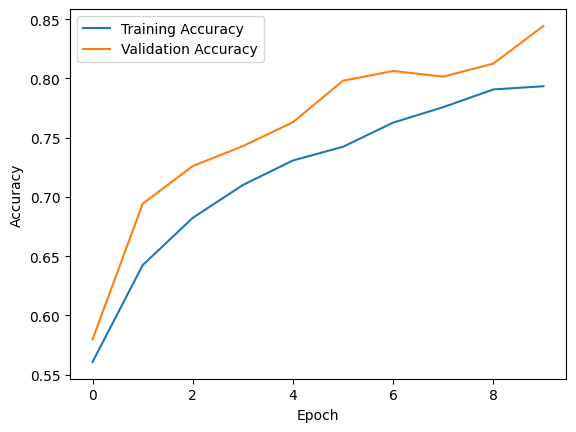

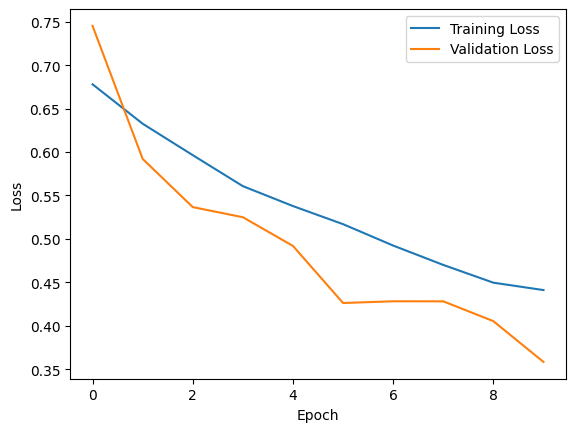

In [13]:
#plot the loss and accuracy
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()